<a href="https://colab.research.google.com/github/Venchislav/Neural-Networks/blob/main/CIFAR10_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

In [2]:
import tensorflow._api.v2.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
(X_train, _), (X_test, _) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [4]:
import matplotlib.pyplot as plt

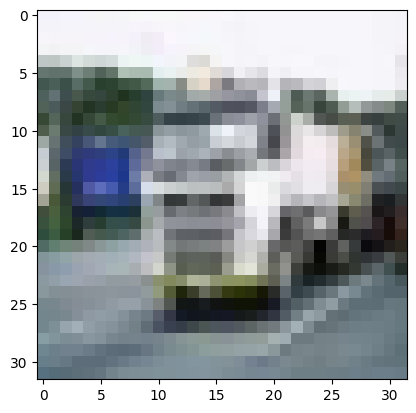

In [5]:
plt.imshow(X_train[1000]);

In [6]:
X_train.shape

(50000, 32, 32, 3)

In [7]:
X_train.max()

255

In [8]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
import numpy as np

In [10]:
from tensorflow.keras import Input, Model
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

In [11]:
dimensions = 4
image_size = X_train.shape[1:]
image_size

(32, 32, 3)

In [12]:
input_img = Input(shape=image_size)
x = layers.Conv2D(16, 3, padding='same', activation='relu')(input_img)
x = layers.MaxPool2D((2, 2))(x)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPool2D((2, 2))(x)

conv_shape = K.int_shape(x)

In [13]:
x = layers.Flatten()(x)

In [14]:
z_mu = layers.Dense(dimensions)(x)
z_sigma = layers.Dense(dimensions)(x)

In [15]:
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [16]:
z = layers.Lambda(sample_z, output_shape=dimensions)([z_mu, z_sigma])

In [17]:
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')

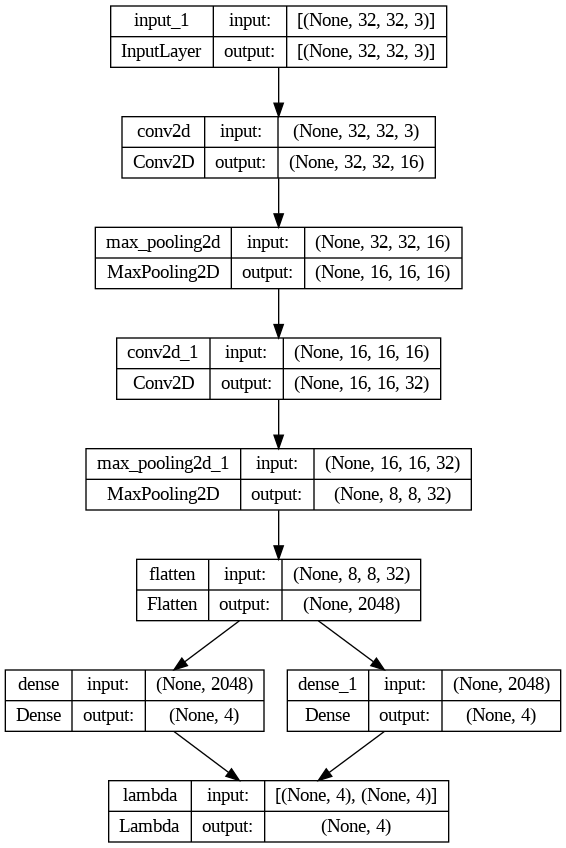

In [18]:
keras.utils.plot_model(encoder, show_shapes=True)

In [19]:
conv_shape[1] * conv_shape[2] * conv_shape[3]

2048

In [20]:
decoder_input = Input(shape=(dimensions,))
x = layers.Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(decoder_input)
x = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2DTranspose(14, 3, padding='same', activation='relu', strides=(2, 2))(x)
output = layers.Conv2DTranspose(3, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, output)

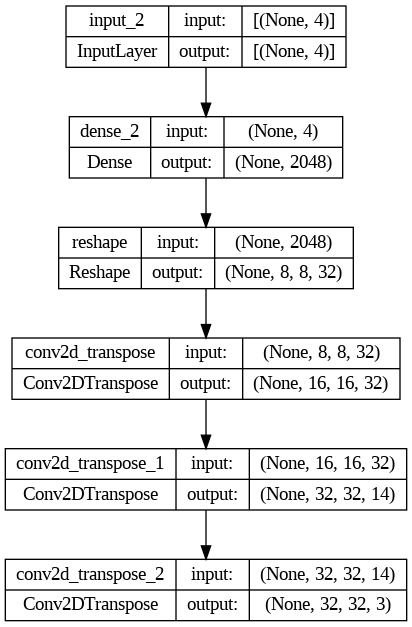

In [21]:
keras.utils.plot_model(decoder, show_shapes=True)

In [22]:
z_decoded = decoder(z)
z_decoded

<tf.Tensor 'model/conv2d_transpose_2/Sigmoid:0' shape=(?, 32, 32, 3) dtype=float32>

In [23]:
class LossLayer(keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)
    recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
    return K.mean(recon_loss + kl_loss)

  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]
    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs=inputs)
    return x

In [24]:
y = LossLayer()([input_img, z_decoded])

In [25]:
vae = Model(input_img, y)

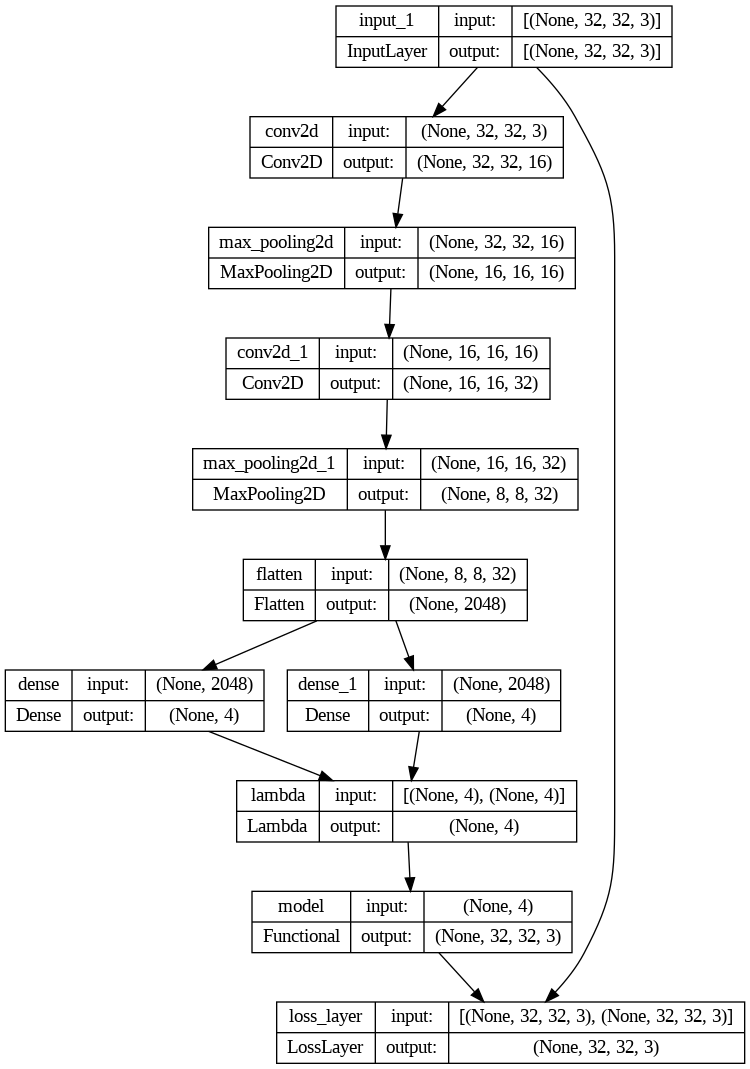

In [26]:
keras.utils.plot_model(vae, show_shapes=True)

In [27]:
vae.compile(
    optimizer='adam',
    loss=None
)

In [28]:
hist = vae.fit(
    X_train, None,
    batch_size=64,
    epochs=15,
    verbose=2,
    validation_split=0.2
)

Train on 40000 samples, validate on 10000 samples
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


40000/40000 - 11s - loss: 0.6498 - val_loss: 0.6313 - 11s/epoch - 268us/sample
Epoch 2/15
40000/40000 - 3s - loss: 0.6255 - val_loss: 0.6249 - 3s/epoch - 84us/sample
Epoch 3/15
40000/40000 - 4s - loss: 0.6241 - val_loss: 0.6244 - 4s/epoch - 91us/sample
Epoch 4/15
40000/40000 - 3s - loss: 0.6237 - val_loss: 0.6239 - 3s/epoch - 82us/sample
Epoch 5/15
40000/40000 - 3s - loss: 0.6234 - val_loss: 0.6237 - 3s/epoch - 83us/sample
Epoch 6/15
40000/40000 - 4s - loss: 0.6232 - val_loss: 0.6235 - 4s/epoch - 93us/sample
Epoch 7/15
40000/40000 - 3s - loss: 0.6231 - val_loss: 0.6235 - 3s/epoch - 81us/sample
Epoch 8/15
40000/40000 - 3s - loss: 0.6229 - val_loss: 0.6234 - 3s/epoch - 81us/sample
Epoch 9/15
40000/40000 - 3s - loss: 0.6227 - val_loss: 0.6230 - 3s/epoch - 87us/sample
Epoch 10/15
40000/40000 - 4s - loss: 0.6225 - val_loss: 0.6229 - 4s/epoch - 88us/sample
Epoch 11/15
40000/40000 - 3s - loss: 0.6223 - val_loss: 0.6227 - 3s/epoch - 82us/sample
Epoch 12/15
40000/40000 - 3s - loss: 0.6222 - val

In [29]:
generated_ones = vae.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


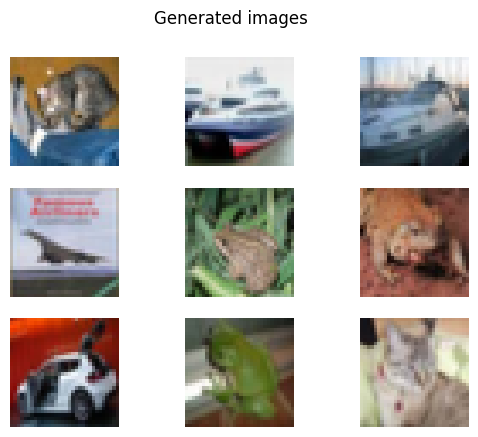

In [30]:
plt.suptitle('Generated images')
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.axis('off')
  plt.imshow(generated_ones[i])

In [57]:
def vae_generate_images(new_to_show=10):
    random_codes = np.random.normal(size=(new_to_show, 4))
    new_faces = decoder.predict(np.array(random_codes))

    fig = plt.figure(figsize=(30, 15))
    fig.suptitle('Fully generated by VAE')
    for i in range(new_to_show):
        ax = fig.add_subplot(6, 10, i+1)
        ax.imshow(new_faces[i])
        ax.axis('off')
    plt.show();

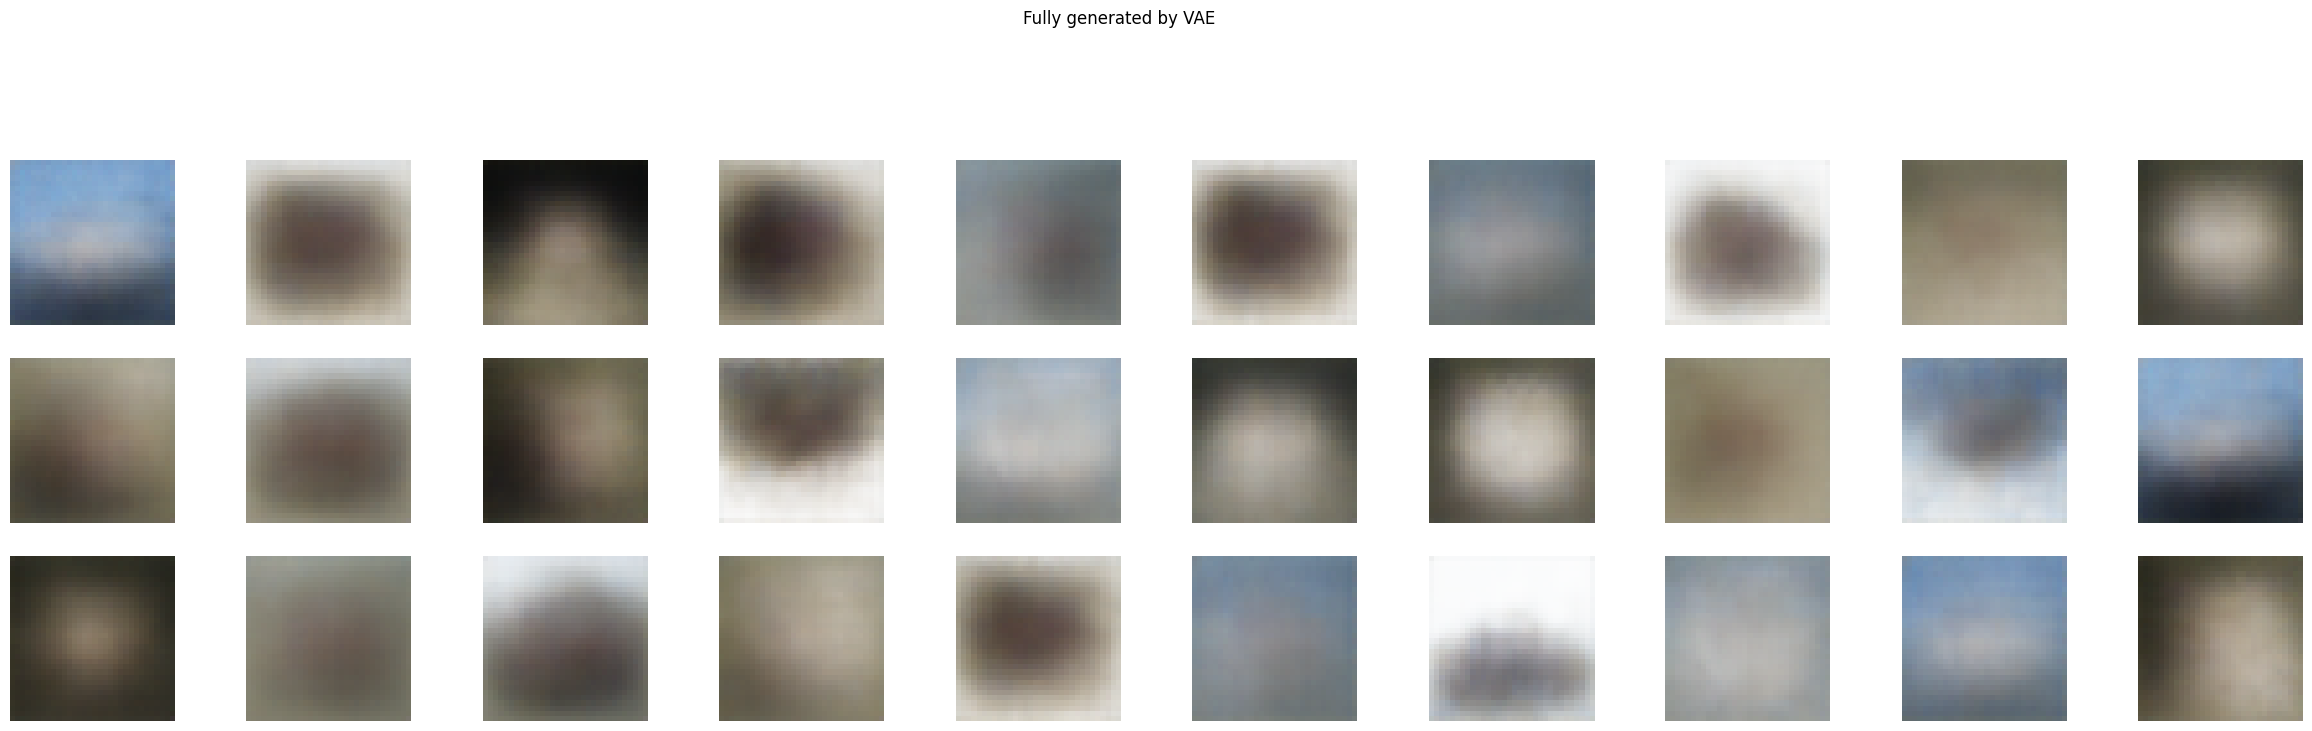

In [58]:
vae_generate_images(30)

These are fully generated...<br>
It may look like they suck (and it's true), but actually it's just because of resolution (32x32)

<img src='https://media.tenor.com/98_jaJe6BRMAAAAi/sad-apple.gif'>
<img src='https://media.tenor.com/98_jaJe6BRMAAAAi/sad-apple.gif'>
<img src='https://media.tenor.com/98_jaJe6BRMAAAAi/sad-apple.gif'>
<img src='https://media.tenor.com/98_jaJe6BRMAAAAi/sad-apple.gif'>
<img src='https://media.tenor.com/98_jaJe6BRMAAAAi/sad-apple.gif'>

These are hard to understand, but we can see something in there.<br>
So it works

<center>GoodBye!</center><br>
<center><img src='https://i.imgflip.com/5m9j60.jpg' width=25%></center>